In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

AI Platform Online Prediction now supports custom python code in to apply custom prediction routines, in this blog post we will perform sentiment analysis using [Twitter data](https://www.kaggle.com/kazanova/sentiment140) and Transfer learning using [Pretrained Glove embeddings](https://nlp.stanford.edu/projects/glove/). This tutorial also uses the new [AI Platform Pipelines](https://cloud.google.com/ai-platform/pipelines/docs) product.


### Dataset

We use the [Twitter data](https://www.kaggle.com/kazanova/sentiment140) which is called `sentiment140` dataset. It contains 1,600,000 tweets extracted using the Twitter AI. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

It contains the following 6 fields:

```
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)
```
The official link regarding the dataset with resources about how it was generated is [here](http://%20http//help.sentiment140.com/for-students/)

### Objective

In this notebook, we show how to deploy a TensorFlow model using AI Platform  Custom Prediction Code using `sentiment140` for sentiment analysis.

### Costs 

This tutorial uses billable components of Google Cloud Platform (GCP):

* Cloud AI Platform
* Cloud Storage

Learn about [Cloud AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or AI Platform Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

2. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

3. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3.

4. Activate that environment and run `pip install jupyter` in a shell to install
   Jupyter.

5. Run `jupyter notebook` in a shell to launch Jupyter.

6. Open this notebook in the Jupyter Notebook Dashboard.

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform APIs and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

If you are running this notebook in Colab, run the following cell to authenticate your Google Cloud Platform user account

In [1]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

## PIP Install Packages and dependencies

In [2]:
!pip install -U tensorflow==1.15.* --user

Requirement already up-to-date: tensorflow==1.15.* in /root/.local/lib/python3.7/site-packages (1.15.5)


In [3]:
import tensorflow as tf

print(tf.__version__)

1.15.5


In [4]:
import pandas as pd
import numpy as np
import os

## 1. Project Configuration

In [5]:
PROJECT_ID = 'vision-api-exp' # TODO (Set to your GCP Project name)
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [6]:
BUCKET_NAME = 'sohini-nlp' # TODO (Set to your GCS Bucket name)
REGION = 'us-central1' #@param {type:"string"}

In [7]:
# Model information.
ROOT = 'ml_pipeline'
MODEL_DIR = os.path.join(ROOT,'models').replace("\\","/")
PACKAGES_DIR = os.path.join(ROOT,'packages').replace("\\","/")

## 2. Get training data

In this step, we are going to:
1. Download Twitter data
2. Load the data to Pandas Dataframe.
3. Convert the class feature (sentiment) from string to a numeric indicator.


Data can be downloaded directly from [here](https://www.kaggle.com/kazanova/sentiment140) (https://www.kaggle.com/kazanova/sentiment140)

It is also located here: `gs://cloud-samples-data/ai-platform/sentiment_analysis/training.csv`

You can copy it by using the following command:

```
gsutil cp gs://cloud-samples-data/ai-platform/sentiment_analysis/training.csv .
```

In [9]:
!gsutil cp gs://cloud-samples-data/ai-platform/sentiment_analysis/training.csv .

Copying gs://cloud-samples-data/ai-platform/sentiment_analysis/training.csv...
\ [1 files][227.7 MiB/227.7 MiB]                                                
Operation completed over 1 objects/227.7 MiB.                                    


### 2.1. Input data

Create a dictionary with a mapping for each label.

In [10]:
sentiment_mapping = {
    0: 'negative',
    2: 'neutral',
    4: 'positive'
}

In [11]:
df_twitter = pd.read_csv('training.csv', encoding='latin1', header=None)\
             .rename(columns={
                 0: 'sentiment',
                 1: 'id',
                 2: 'posted_at',
                 3: 'query',
                 4: 'username',
                 5: 'text'
             })[['sentiment', 'text']]

In [12]:
df_twitter['sentiment_label'] = df_twitter['sentiment'].map(sentiment_mapping)

Verify number of records

In [13]:
df_twitter['sentiment_label'].count()

1600000

In [14]:
df_twitter.head()

,sentiment,text,sentiment_label
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,0,is upset that he can't update his Facebook by ...,negative
2,0,@Kenichan I dived many times for the ball. Man...,negative
3,0,my whole body feels itchy and like its on fire,negative
4,0,"@nationwideclass no, it's not behaving at all....",negative


### 2.2. Data processing fn

In [15]:
%%writefile preprocess.py

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
import re


class TextPreprocessor(object):
    def __init__(self, vocab_size, max_sequence_length):
        self._vocab_size = vocab_size
        self._max_sequence_length = max_sequence_length
        self._tokenizer = None

    def _clean_line(self, text):
        text = re.sub(r"http\S+", "", text)
        text = re.sub(r"@[A-Za-z0-9]+", "", text)
        text = re.sub(r"#[A-Za-z0-9]+", "", text)
        text = text.replace("RT","")
        text = text.lower()
        text = text.strip()
        return text
    
    def fit(self, text_list):        
        # Create vocabulary from input corpus.
        text_list_cleaned = [self._clean_line(txt) for txt in text_list]
        tokenizer = text.Tokenizer(num_words=self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer

    def transform(self, text_list):        
        # Transform text to sequence of integers
        text_list = [self._clean_line(txt) for txt in text_list]
        text_sequence = self._tokenizer.texts_to_sequences(text_list)

        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        padded_text_sequence = sequence.pad_sequences(
          text_sequence, maxlen=self._max_sequence_length)
        return padded_text_sequence

Writing preprocess.py


Some small test:

In [16]:
from preprocess import TextPreprocessor

processor = TextPreprocessor(5, 5)
processor.fit(['hello Google Cloud AI Platform','test'])
processor.transform(['hello Google Cloud AI Platform',"lol"])

array([[0, 1, 2, 3, 4],
       [0, 0, 0, 0, 0]], dtype=int32)

### 2.3.Data preparation

Text preprocessor

In [19]:
CLASSES = {'negative': 0, 'positive': 1}  # label-to-int mapping
VOCAB_SIZE = 25000  # Limit on the number vocabulary size used for tokenization
MAX_SEQUENCE_LENGTH = 50  # Sentences will be truncated/padded to this length

In [21]:
from preprocess import TextPreprocessor
from sklearn.model_selection import train_test_split

sents = df_twitter.text
labels = np.array(df_twitter.sentiment_label.map(CLASSES))

# Train and test split
X, _, y, _ = train_test_split(sents, labels, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Create vocabulary from training corpus.
processor = TextPreprocessor(VOCAB_SIZE, MAX_SEQUENCE_LENGTH)
processor.fit(X_train)

# Preprocess the data
train_texts_vectorized = processor.transform(X_train)
eval_texts_vectorized = processor.transform(X_test)

In [22]:
import pickle

with open('./processor_state.pkl', 'wb') as f:
    pickle.dump(processor, f)

## 3. Model

Create a TensorFlow model

In [23]:
# Hyperparameters

LEARNING_RATE = .001
EMBEDDING_DIM = 50
FILTERS = 64
DROPOUT_RATE = 0.5
POOL_SIZE = 3
NUM_EPOCH = 1
BATCH_SIZE = 32
KERNEL_SIZES = [2, 5, 8]

### 3.1. Basic model

In [24]:
def create_model(vocab_size, embedding_dim, filters, kernel_sizes, dropout_rate, pool_size, embedding_matrix):
    
    # Input layer
    model_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    # Embedding layer
    z = tf.keras.layers.Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        input_length=MAX_SEQUENCE_LENGTH,
        weights=[embedding_matrix]
    )(model_input)

    z = tf.keras.layers.Dropout(dropout_rate)(z)

    # Convolutional block
    conv_blocks = []
    for kernel_size in kernel_sizes:
        conv = tf.keras.layers.Convolution1D(
            filters=filters,
            kernel_size=kernel_size,
            padding='valid',
            activation='relu',
            bias_initializer='random_uniform',
            strides=1)(z)
        conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
        conv = tf.keras.layers.Flatten()(conv)
        conv_blocks.append(conv)
        
    z = tf.keras.layers.Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    z = tf.keras.layers.Dropout(dropout_rate)(z)
    z = tf.keras.layers.Dense(100, activation='relu')(z)
    model_output = tf.keras.layers.Dense(1, activation='sigmoid')(z)
    model = tf.keras.models.Model(model_input, model_output)
    
    return model

### 3.2. Pretrained Glove embeddings

Embeddings can be downloaded from Stanford Glove project: https://nlp.stanford.edu/projects/glove/
- Download file [here](http://nlp.stanford.edu/data/glove.twitter.27B.zip) (http://nlp.stanford.edu/data/glove.twitter.27B.zip)
- Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download)

It is also located here: `gs://cloud-samples-data/ai-platform/sentiment_analysis/glove.twitter.27B.50d.txt`

You can copy it by using the following command:

```
gsutil cp gs://cloud-samples-data/ai-platform/sentiment_analysis/glove.twitter.27B.50d.txt .
```

In [25]:
!gsutil cp gs://cloud-samples-data/ai-platform/sentiment_analysis/glove.twitter.27B.50d.txt .

Copying gs://cloud-samples-data/ai-platform/sentiment_analysis/glove.twitter.27B.50d.txt...
\ [1 files][487.2 MiB/487.2 MiB]                                                
Operation completed over 1 objects/487.2 MiB.                                    


Create an embedding index

In [26]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

In [27]:
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('glove.twitter.27B.50d.txt','r', encoding='utf8'))                                                                                                                                    

In [28]:
word_index = processor._tokenizer.word_index
nb_words = min(VOCAB_SIZE, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= VOCAB_SIZE: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

### 3.3. Create, compile and train TensorFlow model

In [29]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, FILTERS, KERNEL_SIZES, DROPOUT_RATE,POOL_SIZE, embedding_matrix)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [30]:
# Compile model with learning parameters.

optimizer = tf.keras.optimizers.Nadam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
#Keras train

history = model.fit(
    train_texts_vectorized, 
    y_train, 
    epochs=NUM_EPOCH, 
    batch_size=BATCH_SIZE,
    validation_data=(eval_texts_vectorized, y_test),
    verbose=1)#,
#     callbacks=[
#         tf.keras.callbacks.ReduceLROnPlateau(
#             monitor='val_acc',
#             min_delta=0.005,
#             patience=3,
#             factor=0.5),
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             min_delta=0.005, 
#             patience=5, 
#             verbose=0, 
#             mode='auto'
#         ),
#         tf.keras.callbacks.History()
#     ]
# )

Train on 1080000 samples, validate on 360000 samples
1080000/1080000 [==============================] - 1141s 1ms/sample - loss: 0.4777 - acc: 0.7712 - val_loss: 0.4210 - val_acc: 0.8065


In [52]:
from matplotlib import pyplot as plt

In [54]:
history.history

{'acc': [0.7711787],
 'loss': [0.4777020035567107],
 'val_acc': [0.80645],
 'val_loss': [0.42104427699512903]}

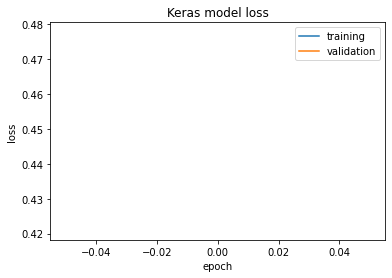

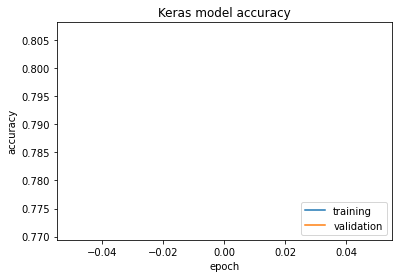

In [55]:
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [57]:
# Export the model to a local SavedModel directory 
export_path = tf.compat.v1.keras.experimental.export_saved_model(model, 'keras_export')
print("Model exported to: ", export_path)

Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatu

In [32]:
with open('history.pkl','wb') as file:
    pickle.dump(history.history,file)

In [46]:
model.save('keras_saved_model.pb')

## 4. Deployment

### 4.1. Prepare custom model prediction

In [47]:
%%writefile custom_prediction.py

import os
import pickle
import numpy as np

from datetime import date
#from google.cloud import logging

import tensorflow.keras as keras


class CustomModelPrediction(object):   
    def __init__(self, model, processor): 
        self._model = model
        self._processor = processor       
    
    def _postprocess(self, predictions):
        labels = ['negative', 'positive']
        return [
            {
                "label":labels[int(np.round(prediction))],
                "score":float(np.round(prediction, 4))
            } for prediction in predictions]
    
    def predict(self, instances, **kwargs):       
        preprocessed_data = self._processor.transform(instances)
        predictions =  self._model.predict(preprocessed_data)
        labels = self._postprocess(predictions)
        return labels

    @classmethod
    def from_path(cls, model_dir):       
        model = keras.models.load_model(
          os.path.join(model_dir,'keras_saved_model.pb'))
        with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
            processor = pickle.load(f)           
        return cls(model, processor)

Overwriting custom_prediction.py


Testing custom prediction locally

In [48]:
from custom_prediction import CustomModelPrediction
classifier = CustomModelPrediction.from_path('.')

In [49]:
requests = (['God I hate the north', 'god I love this'])
response = classifier.predict(requests)
response

[{'label': 'negative', 'score': 0.08569999784231186},
 {'label': 'positive', 'score': 0.9492999911308289}]

### 4.2. Package it

In [50]:
%%writefile setup.py

from setuptools import setup

setup(
  name='tweet_sentiment_classifier',
  version='0.1',
  include_package_data=True,
  scripts=['preprocess.py', 'custom_prediction.py']
)

Overwriting setup.py


Wrap it up and copy to GCP

In [38]:
!python setup.py sdist
!gsutil cp ./dist/tweet_sentiment_classifier-0.1.tar.gz gs://{BUCKET_NAME}/{PACKAGES_DIR}/tweet_sentiment_classifier-0.1.tar.gz

running sdist
running egg_info
creating tweet_sentiment_classifier.egg-info
writing tweet_sentiment_classifier.egg-info/PKG-INFO
writing dependency_links to tweet_sentiment_classifier.egg-info/dependency_links.txt
writing top-level names to tweet_sentiment_classifier.egg-info/top_level.txt
writing manifest file 'tweet_sentiment_classifier.egg-info/SOURCES.txt'
reading manifest file 'tweet_sentiment_classifier.egg-info/SOURCES.txt'
writing manifest file 'tweet_sentiment_classifier.egg-info/SOURCES.txt'

running check


creating tweet_sentiment_classifier-0.1
creating tweet_sentiment_classifier-0.1/tweet_sentiment_classifier.egg-info
copying files to tweet_sentiment_classifier-0.1...
copying custom_prediction.py -> tweet_sentiment_classifier-0.1
copying preprocess.py -> tweet_sentiment_classifier-0.1
copying setup.py -> tweet_sentiment_classifier-0.1
copying tweet_sentiment_classifier.egg-info/PKG-INFO -> tweet_sentiment_classifier-0.1/tweet_sentiment_classifier.egg-info
copying tweet_se

In [59]:
!gsutil cp -r keras_export gs://{BUCKET_NAME}/{MODEL_DIR}/
#!gsutil cp processor_state.pkl gs://{BUCKET_NAME}/{MODEL_DIR}/

Copying file://keras_export/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://keras_export/variables/checkpoint [Content-Type=application/octet-stream]...
Copying file://keras_export/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
Copying file://keras_export/variables/variables.index [Content-Type=application/octet-stream]...
- [4 files][364.8 KiB/364.8 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://keras_export/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://keras_export/assets/saved_model.json [Content-Type=application/json]...
| [6 files][ 20.2 MiB/ 20.2 MiB]                                                
Op

## 5. Create model and version

In [100]:
MODEL_NAME='twitter'
MODEL_VERSION='v1'

RUNTIME_VERSION='1.15'
PYTHON_VERSION='3.7'

In [101]:
!gcloud ai-platform models create {MODEL_NAME} --regions {REGION}

Using endpoint [https://ml.googleapis.com/]
Created ai platform model [projects/vision-api-exp/models/twitter].


In [102]:
! echo {BUCKET_NAME}/{MODEL_DIR}

sohini-nlp/ml_pipeline/models


In [103]:
!gcloud ai-platform versions create v1 --model twitter --origin gs://sohini-nlp/ml_pipeline/models/keras_export --python-version 3.7 --runtime-version 1.15 --region {REGION} --framework tensorflow


Using endpoint [https://us-central1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.versions.create) NOT_FOUND: Field: parent Error: The model resource: "twitter" was not found. Please create the model resource first by using 'gcloud ai-platform models create twitter'.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: "The model resource: \"twitter\" was not found. Please create the\
      \ model resource first by using 'gcloud ai-platform models create twitter'."
    field: parent


## 6. Testing

In [61]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

In [104]:
requests = [
    'god this episode is bad',
    'meh, I kinda like it',
    'what were the writer thinking, omg!',
    'omg! what a twist, who would\'ve though :o!',
    'woohoow, sansa for the win!'
]

In [105]:
# JSON format the requests
request_data = {'instances': requests}

In [106]:
with open('prediction_input.json', 'w') as json_file:
  for row in request_data:
    json.dump(row, json_file)
    json_file.write('\n')

In [107]:
! echo $REGION

us-central1


In [108]:
%%bash

gcloud ai-platform predict --model twitter --version v1 --json-instances ./prediction_input.json --region us-central1

Using endpoint [https://us-central1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.predict) NOT_FOUND: Field: name Error: The model resource: "twitter" was not found. Please create the model resource first by using 'gcloud ai-platform models create twitter'.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: "The model resource: \"twitter\" was not found. Please create the\
      \ model resource first by using 'gcloud ai-platform models create twitter'."
    field: name
